<center><h1>Tutorial 1 - Hard-Sphere Fluids </h1>
<br>Mary K. Coe <br>
23 Oct 2021</center>

By the end of this tutorial you will be able to
    - Obtain the equilibrium density profile of a hard-sphere fluid in contact with a wall, solute or confined in a slit.
    - Plot this density profile.
    - Determine the numerical consistency of the density profile using two sum rules.


<h3>Introduction</h3>
This tutorial assumes that you already have a general understanding of what classical density functional theory (cDFT) is and how it works. If this is not the case, then it is recommended you check out the following references

<a href = "https://doi.org/10.1080/00018737900101365"> R. Evans, Advances in Physics <b>28</b>, 143-200 (1979)</a> - This is a famous review article by Prof Bob Evans which covers most of the maths behind cDFT.

<a href="https://doi.org/10.1088/0953-8984/22/6/063102">R Roth, J. Phys.:Condens. Matter <b>22</b>, 0631102 (2010)</a> - This is a review article by Prof Roland Roth which covers the theory and implementation of Fundamental Measure Theory (FMT). This also describes all functionals available within the package.

<a href = https://research-information.bris.ac.uk/ws/portalfiles/portal/304220732/Thesis_Mary_Coe.pdf>M. K. Coe, "Hydrophobicity across length scales: The role of surface criticality", PhD thesis, (University of Bristol, 2021)</a> - My thesis. Chapter 4 as well as Appendices A-C cover the implementation of cDFT within this package in depth.

Within this tutorial, you will learn how to use the cDFT package to find the equilibrium density profiles of one-component hard-sphere fluids in contact with hard planar walls, hard spherical walls (or solutes) and confined to a slit with hard walls. This package implements cDFT as described in the articles by Evans and Roth, using Rosenfeld's FMT to describe the excess Helmholtz free energy of the hard-sphere fluid. This package supports three functionals - the original <a href = "https://doi.org/10.1103/PhysRevLett.63.980">Rosenfeld functional</a>, the <a href="https://doi.org/10.1088/0953-8984/14/46/313">White-Bear functional</a> and the <a href="https://doi.org/10.1088/0953-8984/18/37/002">White-Bear Mark II functional</a>. Within this tutorial, we will cover each of these.

In addition to a basic knowledge of cDFT, you will need a Python installation with the standard libraries, as well as the <i>NumPy</i>, <i>SciPy</i>, <i>Matplotlib</i> and <i>pyfftw</i> libraries. The latter of these is the python wrapper for the fast fourier transforms library, FFTW. 

<b>Warning</b> - I have noticed that pyfftw does not respect core allocation on nodes on a cluster. For example, if you request one core on one node, pyfftw appears to automatically use all cores within the node. If using the package on a cluster, it is therefore recommended you run it using mpiexec or equivalent, to force it to use only the requested number of cores.

With this in mind, we begin the tutorial by importing necessary libraries.

In [5]:
# Import necessary libraries for tutorial
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors

<h3>Package Layout</h3>

The cDFT package consists of six modules. Of these, only two need actually be called in order to perform cDFT - all others are for internal operations and therefore are likely only of interest to developers.

The two modules used regularly when performing cDFT are <i>cDFT.minimisation</i> and <i>cDFT.measures</i>. The first of these holds objects specifically relating to the minimisation procedure, whilst the second contains measures which may be of interest, such as the surface tension and grand potential. It should be noted that many of the measures of interest can actually be calculated during the minimisation procedure by supplying various flags to the minimisation objects. These will be introduced throughout these tutorials.

The <i>cDFT.minimisation</i> modules contains four objects which control various aspects of the cDFT minimisation procedure. These are split into geometry-specifc objects, which control whether a planar wall, spherical wall or slit should be considered, and a non-geometry specific object, <i>cDFT.minimisation.DFT</i>, which controls fluid and grid parameters. The general procedure is to define a <i>cDFT.minimisation.DFT</i> and then supply this to a geometry -specific object (<i>cDFT.minimisation.planar</i>,<i>cDFT.minimisation.spherical</i> or <i>cDFT.minimisation.slit</i>). These latter objects contain <i>minimise</i> methods which allow for the equilibrium density profile to be found.

This tutorial is set out as follows. Firstly, we consider a hard-sphere fluid in contact with a planar hard wall and investigate the functionals available. We then consider spherical hard walls of various radii, before finally studying a hard-sphere fluid within a slit. <b>It should be noted that this package only supports one-component fluids and smooth walls.</b> This allows it to be efficient, as the equilibrium density profile will vary along only one axis and hence only a one-dimensional grid is required. For more information, see <a href="https://doi.org/10.1088/0953-8984/22/6/063102">R Roth, J. Phys.:Condens. Matter <b>22</b>, 0631102 (2010)</a>.

<h3>How to Read the Output Files</h3>

Whenever you call the <i>minimise</i> method (see below), an output file will be generated and saved. By default, this is saved to a folder called <i>cDFT_Results</i> however you can specify the desired output folder using the <i>file_path</i> parameter, available for all geometries discussed below. The name of the output file takes the form: 

(geometry abbreviation)(wall type(s))\_(fluid type)\_(radius of wall if applicable)\_(bulk density)\_(temperature)\_(hard-sphere functional abbreviation)

The geometry abbreviations are <i>P</i> for a planar wall, <i>S</i> for a spherical wall (solute) and <i>SL</i> for a slit. All other abbreviations are explained as you progress through the tutorials.

The output file is structured as follows:

<b>Header</b> - The header to the output file contains information about the system such as the geometry, the temperature (T), density, grid size in units of fluid particle diameters (L), number of grid points (N), distance between grid points in units of fluid particle diameters (dr) and more. 

<b>Profile</b> - After the header, the equilibrium profile is printed. This is structured as grid_point (i) physical distance (r) density (rho) density scaled by bulk density (rho/rho_b). 

<b>Footer</b> - After the profile, the results of the adsorption sum rule (explained below) are printed. Any other measures you call to be output to file will also go here.

Other outputs will be explained throughout these tutorials.

<h3>Planar Hard Wall </h3>
We begin by defining the non-geometry specific object. This takes a minimimum of three arguments - the density of the hard-sphere fluid in the bulk (<i>bulk_density</i>), the temperature (<i>temperature</i>) and the fluid type (<i>fluid_type</i>). Within this tutorial, the latter with be a hard-sphere fluid, <b>fluid_type = 'HS'</b>. The temperature has no physical meaning within a hard-sphere fluid, so will be set to <b>temperature = 1.0</b>. Rather than density, it is more convenient to work with packing fractions with hard-sphere fluids, hence the function <i>density_from_packing_fraction</i> is supplied. Using these we then define the non-geometry specfic <i>DFT</i> object.

In [6]:
import cDFT.minimisation as minimise

def density_from_packing_fraction(packing_fraction):
    """
    Calculates the density of a hard-sphere fluid from
    the packing fraction.
    
    Args:
        packing_fraction(float): hard-sphere fluid packing fraction
    Returns:
        density(float): density of hard-sphere fluid
    """
    
    # Note that the diameter of a fluid particle is
    # set to 1.0
    density = 6.*packing_fraction/np.pi
    
    return density

# Calculate the density of a hard-sphere fluid with
# packing fraction 0.2
density = density_from_packing_fraction(0.2)

# Define a DFT object
DFT = minimise.DFT( bulk_density=density,
                    temperature=1.0,
                    fluid_type='HS')

At any point we can check the parameters using the <i>information</i> method.

In [7]:
DFT.information()

Fluid type: hard-sphere
Temperature: 1.0
Density of bulk fluid: 0.3819718634205489
Functional: Rosenfeld
Length of grid: 50.0 * diameter of a fluid particle
Distance between grid points: 0.001 * diameter of a fluid particle


From this we can also see other parameters which can be set. These are the functional (<i>functional =</i>), the length of the grid (<i>L =</i>) and the distance between the grid points, or the discretisation (<i>dr</i>). We'll return to these later. 

We then define our geometry specfic object. Within this section, this is the <i>planar</i> object. It takes a minimum of two arguments - a DFT object (<i>cDFT = </i>) and a wall type (<i>wall_type =</i>). We will consider a hard wall (<b>wall_type = 'HW'</b>).

In [8]:
planar = minimise.planar(cDFT=DFT,
                         wall_type='HW')

Again, if we want to check the paramaters of our object at any time, we can use the <i>information</i> method.

In [9]:
planar.information()

Geometry: Planar Wall
Wall type: Hard Wall
Picard mixing parameter: 0.1
Ng move frequency: 10 picard moves
Output local compressibility: False
Output local thermal susceptibility: False


This also shows other parameters which can be set. The middle two of these, 'Picard mixing parameter' and 'Ng move frequency' relate to the methods used within the package when updating the density profile during the minimisation procedure. The default arguments will normally suffice for a hard-sphere fluid - the exception to this is for very dense packing fractions which will be discussed later. The latter two parameters will be discussed in Tutorial 3. 

To find the equilibrium density profile, we use the <i>minimise<i/> method.

In [10]:
planar.minimise()

Convergence achieved in 76 attempts.


The method minimises the grand potential of the fluid to its equilibrium value using the method outlined in the Introduction. We can then visualise the profile using the <i>plot</i> method.

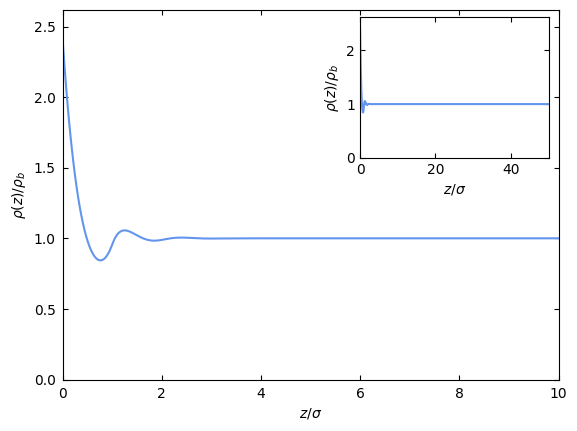

In [11]:
planar.plot()    

Here we have plotted in relation to the bulk density. This can be accessed using <i>planar.DFT.bulk_density</i>.

The numerical consistency of the procedure can be checked using statistical mechanics sum rules. These are formally exact equations which relate microscopic and macroscopic properties of a system. The cDFT package implements two sum rules - the adsorption sum rule and the contact theorem sum rule, see section 4.1.5 of my thesis (link to be added when available) for more details. It does so by calculating either side of the equation separately, and then comparing them to find the relative error. If the minimisation is numerically consistent, this error should be small.

The appropriate form of the contact theorem can be accessed using the <i>contact_sum_rule</i> method.

In [12]:
planar.contact_sum_rule()


--------------------------------------------
Contact Sum Rule Results:
pressure = 0.9250881067
kbT*rho(0) = 0.9250876743
Relative Error = 0.0000004674
--------------------------------------------


The relative error here for a packing fraction of 0.2 and default grid parameters should be in the region of the seventh decimal place. This shows that the minimisation procedure obeyed the sum rule. (Note - the lines above the relative error relate to the variables on either side of the sum rule. More details can be found in my thesis).

The adsorption sum rule can be accessed using the <i>adsorption_sum_rule</i> method.

In [13]:
planar.adsorption_sum_rule()


--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = 0.0860102439
-dgamma/dmu = 0.0863166875
Relative error = 0.0035628733
--------------------------------------------


This sum rule is also obeyed however features a larger relative error. This is due to the numerical derivative required during its evaluation. In general, for the default parameters, this sum rule should be obeyed to three decimal places.

As mentioned above, the package supports three functionals - Rosenfeld (RF), White-Bear (WB) and White-Bear Mark II (WBII). At low packing fractions, these give near identical equilibrium density profiles. The same is not true for high packing fractions near to the freezing transition. This is due to the different equations of state underlying each functional - see the references above for more details. We can see these differences clearly for a packing fraction of 0.42. For such a dense fluid, the default Picard mixing and Ng move frequency will cause the minimisation procedure to overshoot and oscillate. To ensure stability, it is therefore necessary to reduce the former and increase the latter. Below is a function which compares all functionals available. <b>Note - This code will take approximately an hour to run.</b> 

In [14]:
def compare_functionals(packing_fraction, picard_mixing = 0.1, ng = 10):
    """
    Compares all functionals available for a given
    packing fraction.
    
    Args:
        None
    Returns:
        None
    """
    # Calculate the density of a hard-sphere fluid
    density = density_from_packing_fraction(packing_fraction)

    # Define functionals
    RF = minimise.DFT(bulk_density=density, temperature=1.0, fluid_type='HS', functional = 'RF')
    WB = minimise.DFT(bulk_density=density, temperature=1.0, fluid_type='HS', functional = 'WB')
    WBII = minimise.DFT(bulk_density=density, temperature=1.0, fluid_type='HS', functional = 'WBII')
    
    # Define geometry
    planar_RF = minimise.planar(RF, wall_type = 'HW', alpha = picard_mixing, ng = ng)
    planar_WB = minimise.planar(WB, wall_type = 'HW', alpha = picard_mixing, ng = ng)
    planar_WBII = minimise.planar(WBII, wall_type = 'HW', alpha = picard_mixing, ng = ng)
    
    # Find equilibrium profile
    planar_RF.minimise()
    planar_WB.minimise()
    planar_WBII.minimise()
    
    # Plot
    z, RF_density = planar_RF.equilibrium_profile()
    z, WB_density = planar_WB.equilibrium_profile()
    z, WBII_density = planar_WBII.equilibrium_profile()
    
    fig = plt.figure()
    ax_main = fig.add_subplot(111)
    ax_inset = ax_main.inset_axes([0.55,0.55,0.4,0.4], 
                                 transform = ax_main.transAxes)
    
    L = int(0.2*planar.DFT.L/planar.DFT.dr)
    ax_main.plot(z[:L], RF_density[:L]/density, color = 'steelblue',
                label = 'Rosenfeld', ls='solid')
    ax_main.plot(z[:L], WB_density[:L]/density, color = 'palevioletred',
                label = 'White-Bear', ls='dashed')
    ax_main.plot(z[:L], WBII_density[:L]/density, color = 'rosybrown',
                label = 'White-Bear Mark II', ls='dotted')
    
    contact = 0.5*np.ceil(RF_density[0]/(density*0.5))
    ax_main.set_xlim(0.0,z[L])
    ax_main.set_ylim(0.0,contact)
    ax_main.tick_params(right=True, top=True, direction='in')
    ax_main.set_xlabel(r'$z/\sigma$')
    ax_main.set_ylabel(r'$\rho(z)/\rho_b$')
    ax_main.legend(loc = 'upper left', frameon = False)
    
    L = int(0.001*planar.DFT.L/planar.DFT.dr)
    ax_inset.plot(z[:L], RF_density[:L]/density, color = 'steelblue', ls='solid')
    ax_inset.plot(z[:L], WB_density[:L]/density, color = 'palevioletred', ls='dashed')
    ax_inset.plot(z[:L], WBII_density[:L]/density, color = 'rosybrown', ls='dotted')
    
    ax_inset.set_xlim(0.0,z[L])
    ax_inset.tick_params(right=True, top=True, direction='in')
    ax_inset.set_xlabel(r'$z/\sigma$')
    ax_inset.set_ylabel(r'$\rho(z)/\rho_b$')

#compare_functionals(packing_fraction=0.42, picard_mixing = 0.001, ng = 1000000)

It should be further noted that none of these functionals are able to accurately reproduce the freezing transition due to a diverging free energy term in the one-dimensional limit. An accurate description of a hard-sphere crystal in fact requires tensorial weighted densities. These are not supported within the package.  

<h3>Spherical Hard Wall (Solute)</h3>
Spherical external potentials, or solutes, can be declared using <i>minimise.spherical</i>. Like the <i>minimise.planar</i> object, this takes a <i>minimise.DFT</i> object and <i>wall_type</i> as required arguments. In addition, a radius for the solute, in units of fluid particle diameters, must be supplied (<i>Rs</i>). Rs can take any value larger than 1. Once declared, properties of the object can be viewed using the <i>information</i> method.

In [15]:
solute = minimise.spherical(DFT,
                            Rs = 100.0,
                            wall_type = 'HW')

solute.information()

Geometry: Spherical Wall
Radius: 100.0 * diameter of a fluid particle
Wall type: Hard Wall
Picard mixing parameter: 0.1
Ng move frequency: 10 picard moves
Output local compressibility: False
Output local thermal susceptibility: False


It should be noted that the package defines the density profile from the centre of the fluid particles and the radius of the spherical wall as the first point at which the density profile becomes non-zero. The importance of this will become evident when considering a test particle below. For more information on the system set up please consult my thesis (available December 2021) or <a href = https://doi.org/10.1103/PhysRevE.68.031602>this paper</a>. 

The equilibrium density profile is found using the <i>minimise</i> method. Once this has been found, the numerical consistency of the minimisation can be tested using the adsorption and contact sum rules. The adsorption sum rule is found in the same way irrespective of wall geometry. In contrast, the contact sum rule is found differently and can in fact take two forms. The package will calculate each of these. For more information on these sum rules, please see this paper.

In [16]:
solute.minimise()
solute.adsorption_sum_rule()
solute.contact_sum_rule()

Convergence achieved in 75 attempts.

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = 0.0857785568
-dgamma/dmu = 0.0860842126
Relative error = 0.0035633121
--------------------------------------------

----------------------------------------------------
Contact Sum Rule A:
beta*d(omega)/(dRb) = 115901.5102799497
4piRs^2rho(Rs) = 115899.8385251115
Relative Error = 0.0000144241

Contact Sum Rule B:
kbTrho(Rs) = 0.9223016102
p + 2gamma/Rs + dgamma/dRs = 0.9222872169
Relative Error = 0.0000156059
-----------------------------------------------------


The adsorption sum rule is satisfied to the same precision as in the planar wall case. The agreement in either form of the contact sum rule is not as good as in the planar case, typically only agreeing to five decimal places. This is to be expected due to the necessity to evaluate a numerical derivative.

The solute profile can be plotted in much the same way as in the case of a planar wall and takes much the same form.

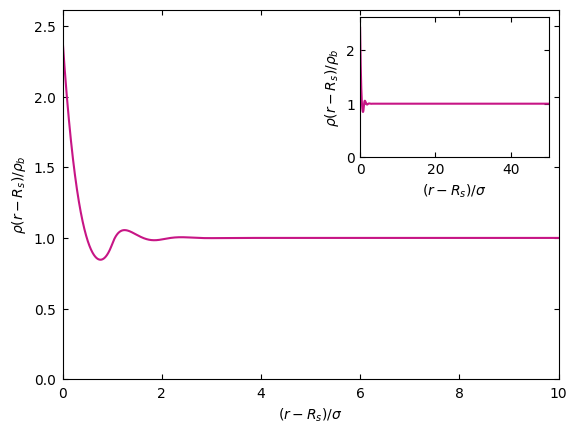

In [17]:
solute.plot()

The package also supports the study of a hard-sphere test particle. As the density profile is measured from the centre of the fluid particles, the radius of the spherical wall should be set to <i>Rs=1</i> for a test particle. 

Geometry: Spherical Wall
Radius: 1.0 * diameter of a fluid particle
Wall type: Hard Wall
Picard mixing parameter: 0.1
Ng move frequency: 10 picard moves
Output local compressibility: False
Output local thermal susceptibility: False

Convergence achieved in 72 attempts.

--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = 0.0649433777
-dgamma/dmu = 0.0652287631
Relative error = 0.0043943717
--------------------------------------------

----------------------------------------------------
Contact Sum Rule A:
beta*d(omega)/(dRb) = 8.4998489474
4piRs^2rho(Rs) = 8.4877784924
Relative Error = 0.0014220983

Contact Sum Rule B:
kbTrho(Rs) = 0.6754359515
p + 2gamma/Rs + dgamma/dRs = 0.6742878867
Relative Error = 0.0016997389
-----------------------------------------------------


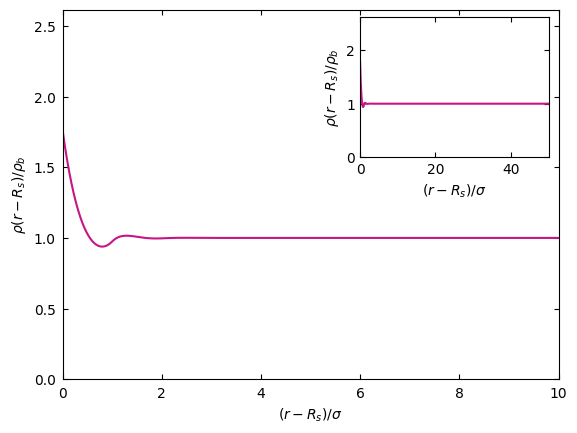

In [18]:
def test_particle():
    """
    Finds the equilibrium density profile of a hard-sphere test particle
    for the Rosenfeld functional. Prints the results of the adsorption
    and contact sum rules and plots the equilibrium density profile.
    
    Args:
        None
    Returns:
        None
    """
    # Calculate the density of a hard-sphere fluid with
    # packing fraction 0.2
    density = density_from_packing_fraction(0.2)

    # Define a DFT object
    DFT = minimise.DFT(bulk_density=density,
                       temperature=1.0,
                       fluid_type='HS')
    
    test_part = minimise.spherical(DFT,
                                    Rs=1.0,
                                    wall_type = 'HW')
    test_part.information()
    print(f'\n')
    test_part.minimise()
    test_part.plot()
    test_part.adsorption_sum_rule()
    test_part.contact_sum_rule()
  
test_particle()

The agreement in the sum rules will decrease for the hard-sphere test particle and should all be of order three decimal places.

<h3>Slit</h3>
The final geometry supported in the package is a slit geometry. This is initialised using the <i>slit</i> object, which takes a DFT object along with the types of each wall as required arguments.

In [91]:
# Define a DFT object 0.304665 0.700782 0.856918
DFT = minimise.DFT(bulk_density=0.856918,
                   temperature=1.0,
                   fluid_type='HS', functional = 'WB')

# Define slit object
planar = minimise.planar(DFT,
                     wall_type = 'HW', ng=1000, alpha=0.001)

# Print information about object
planar.information()

Geometry: Planar Wall
Wall type: Hard Wall
Picard mixing parameter: 0.001
Ng move frequency: 1000 picard moves
Output local compressibility: False
Output local thermal susceptibility: False


1000 complete. Deviation: 0.0009258896449342302
2000 complete. Deviation: 1.0008759821822366e-05
3000 complete. Deviation: 1.7599387396316502e-06
4000 complete. Deviation: 9.528246458501144e-08
5000 complete. Deviation: 1.0694535035327135e-08
6000 complete. Deviation: 5.901794608575983e-10
7000 complete. Deviation: 5.994493790240085e-11
8000 complete. Deviation: 1.3452350344778097e-11
9000 complete. Deviation: 1.935340776526573e-12
Convergence achieved in 9243 attempts.


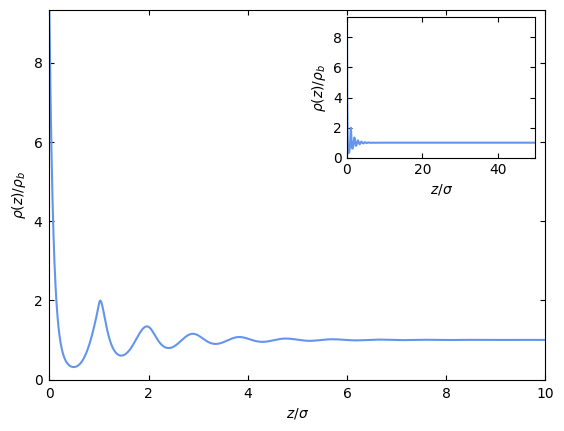

In [92]:
planar.minimise()
planar.plot()

In [93]:
L = int(10./planar.DFT.dr) + planar.NiW
print(planar.DFT.density[planar.NiW], planar.DFT.density[L]) # 4.010870685093517 0.700793351282625

7.975523168281016 0.8564388602770862


The numerical consistency can then be calculated using the <i>adsorption_sum_rule</i> and <i>contact_sum_rule</i> as before. More information about the form of the contact sum rule for a slit can be found in <a href = https://doi.org/10.1103/PhysRevE.86.031601>this paper</a>.

In [21]:
slit.adsorption_sum_rule()
slit.contact_sum_rule()


--------------------------------------------
Adsorption Sum Rule Results:
Gamma/A = 0.1720204877
-dgamma/dmu = 0.1726332504
Relative error = 0.0035621495
--------------------------------------------

----------------------------------------------------
Left Wall = 0.00000000000001
Right Wall = 0.00000000000001
Relative Error = 0.00000000000000
------------------------------------------------------


As in all other supported geometries, the adsorption sum rule is satisfied to at least three decimal places, whilst the contact sum rule is satisfied to far more.

<h3>Up Next</h3>
Within this tutorial, the abilities of the package with respect to hard-sphere fluids and hard walls/solutes has been outlined. In the next tutorial, we will consider the abilities of the package to represent Lennard-Jones fluids in each of the geomeries above, in addition to considering attractive wall/solute-fluid interactions.